In [1]:
%run Jansen_And_Rit.py

In [6]:
x1, x2, x3, V_T_sim = run_jansen_and_rit(100) # Just takes C for now

In [7]:
%store V_T_sim

Stored 'V_T_sim' (ndarray)


In [12]:
emp_spec = np.load('emp_spec.npy', allow_pickle=True).item()  # Load as a dictionary

gen_data = V_T_sim.T
fake_info = mne.create_info(100, sfreq=eeg_freq, ch_types='eeg')
gen_raw = mne.io.RawArray(gen_data, fake_info)
gen_spec = gen_raw.compute_psd(fmin=0, fmax=80, picks="all", n_jobs=-1)

# Trims the data to the same number of time samples, marginal diff (161 to 168, as empirical over 8 seconds and generated over 2)
time_samples = min(gen_spec._data.shape[1], emp_spec._data.shape[1])
gen_spec_data = gen_spec._data[:, :time_samples]
emp_spec_data = emp_spec._data[:, :time_samples]

# Calculates the mean PSD for both empirical and generated data
mean_gen_psd = np.mean(gen_spec_data, axis=0)
mean_emp_psd = np.mean(emp_spec_data, axis=0)

correlation_coefficient, _ = pearsonr(mean_gen_psd, mean_emp_psd)
print("Pearson correlation coefficient between mean empirical and mean generated PSD:", correlation_coefficient)

Creating RawArray with float64 data, n_channels=100, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     1.999 secs
Ready.
Effective window size : 2.000 (s)


Pearson correlation coefficient between mean empirical and mean generated PSD: 0.745025357157915


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [2]:
def find_eeg_loss(x):
    print(x[0])
    x1, x2, x3, V_T_sim = run_jansen_and_rit(x[0]) # Just takes C for now
    emp_spec = np.load('emp_spec.npy', allow_pickle=True).item()  # Load as a dictionary

    gen_data = V_T_sim.T
    fake_info = mne.create_info(100, sfreq=eeg_freq, ch_types='eeg')
    gen_raw = mne.io.RawArray(gen_data, fake_info)
    gen_spec = gen_raw.compute_psd(fmin=0, fmax=80, picks="all", n_jobs=-1)

    # Trims the data to the same number of time samples, marginal diff (161 to 168, as empirical over 8 seconds and generated over 2)
    time_samples = min(gen_spec._data.shape[1], emp_spec._data.shape[1])
    gen_spec_data = gen_spec._data[:, :time_samples]
    emp_spec_data = emp_spec._data[:, :time_samples]

    # Calculates the mean PSD for both empirical and generated data
    mean_gen_psd = np.mean(gen_spec_data, axis=0)
    mean_emp_psd = np.mean(emp_spec_data, axis=0)

    correlation_coefficient, _ = pearsonr(mean_gen_psd, mean_emp_psd)

    # The closer the correlation is to 1 or -1, the smaller the loss
    # So want to minimise loss
    loss = (abs(correlation_coefficient) - 1) ** 2 # Penalises deviations from 1 or -1 
    return loss

In [3]:
from skopt import gp_minimize
np.random.seed(123)
res = gp_minimize(find_eeg_loss, [(100, 150)], n_calls=10, n_jobs=-1, acq_optimizer='lbfgs')
print("x*=%.2f f(x*)=%.2f" % (res.x[0], res.fun))

136


KeyboardInterrupt: 

https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

c:\Users\stapl\anaconda3\envs\nilearnenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


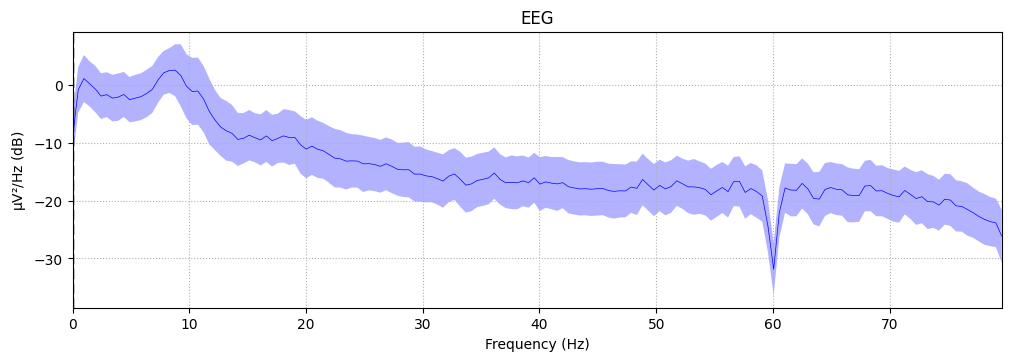

c:\Users\stapl\anaconda3\envs\nilearnenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


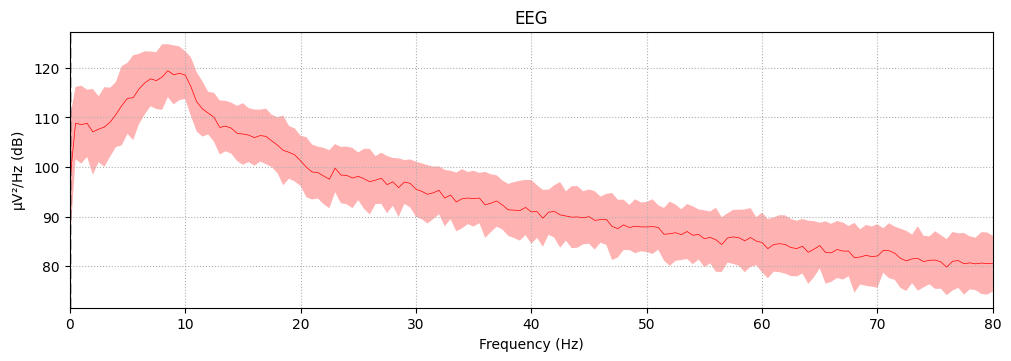

In [19]:
# To Draw Figs
fig = emp_spec.plot(picks="all", average=True, color="Blue");
plt.show(fig)
plt.close(fig)

fig = gen_spec.plot(picks="all", average=True, color="Red"); 
plt.show(fig)
plt.close(fig)